<h1 style="color: #3498db;text-align: center;">BRONZE TO SILVER</h1>

# Introduction
This notebook will show the data transformation process from the Bronze layer to the Silver layer, including cleaning, outlier removal, and feature engineering.

In [8]:
import pandas as pd             # For data manipulation and analysis
import numpy as np              # For numerical operations and transformations
import seaborn as sns           # For visualizations
import matplotlib.pyplot as plt  # For plotting graphs
import re                       # For text cleaning and regular expressions
from sklearn.preprocessing import MinMaxScaler  # For scaling the numeric values
from pathlib import Path

In [9]:
csv_file_path = Path("bronze") / "songs_with_attributes_and_lyrics.csv"
# Load the dataset using pandas
df = pd.read_csv(csv_file_path)

In [11]:
# Initial inspection
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955320 entries, 0 to 955319
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                955320 non-null  object 
 1   name              955311 non-null  object 
 2   album_name        385562 non-null  object 
 3   artists           955318 non-null  object 
 4   danceability      955320 non-null  float64
 5   energy            955320 non-null  float64
 6   key               955320 non-null  object 
 7   loudness          955320 non-null  float64
 8   mode              955320 non-null  object 
 9   speechiness       955320 non-null  float64
 10  acousticness      955320 non-null  float64
 11  instrumentalness  955320 non-null  float64
 12  liveness          955320 non-null  float64
 13  valence           955320 non-null  float64
 14  tempo             955320 non-null  float64
 15  duration_ms       955320 non-null  float64
 16  lyrics            95

In [12]:
df.head()

,id,name,album_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,lyrics
0,0Prct5TDjAnEgIqbxcldY9,!,UNDEN!ABLE,['HELLYEAH'],0.415,0.6050,7,-11.157,1,0.0575,0.00116,0.838000,0.4710,0.193,100.059,79500.0,"He said he came from Jamaica,\n he owned a cou..."
1,2ASl4wirkeYm3OWZxXKYuq,!!,NaN,Yxngxr1,0.788,0.6480,7,-9.135,0,0.3150,0.90000,0.000000,0.1760,0.287,79.998,114000.0,"Fucked a bitch, now she running with my kids\n..."
2,69lcggVPmOr9cvPx9kLiiN,!!! - Interlude,Where I Belong EP,['Glowie'],0.000,0.0354,7,-20.151,0,0.0000,0.90800,0.000000,0.4790,0.000,0.000,11413.0,"Oh, my God, I'm going crazy\n"
3,4U7dlZjg1s9pjdppqZy0fm,!!De Repente!!,Un Palo Al Agua (20 Grandes Canciones),['Rosendo'],0.657,0.8820,5,-6.340,1,0.0385,0.00740,0.000013,0.0474,0.939,123.588,198173.0,Continuamente se extraña la gente si no puede ...
4,4v1IBp3Y3rpkWmWzIlkYju,!!De Repente!!,Fuera De Lugar,['Rosendo'],0.659,0.8930,5,-8.531,1,0.0411,0.09220,0.000019,0.0534,0.951,123.600,199827.0,Continuamente se extraña la gente si no puede ...


In [13]:
print(df.isnull().sum())

id                       0
name                     9
album_name          569758
artists                  2
danceability             0
energy                   0
key                      0
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness         0
liveness                 0
valence                  0
tempo                    0
duration_ms              0
lyrics                  13
dtype: int64


# Section 1: Data Cleaning & Pre-processing
The first step of the analysis involves cleaning the dataset to remove inconsistencies in the data columns, missing values or remove unecessary columns.

### 1.1 Dropping album_name column
The album_name column has too many missing values to be useful. Therefore, we decided to drop it to avoid unnecessary complications in the analysis. 


In [14]:
# Drop the 'album_name' column
df.drop(columns=['album_name'], inplace=True)

### 1.2 Handling Missing Values

In this step, we fill the missing values present in the `name`, `artists`, and `lyrics` columns. We will fill the missing values with placeholders:
For:
- **name**: Replaced missing entries with "Unknown Name".
- **artists**: Replaced missing entries with "Unknown Artist".
- **lyrics**: Replaced missing entries with "Missing Lyrics".


In [15]:
df['name'].fillna('Unknown Name', inplace=True)
df['artists'].fillna('Unknown Artist', inplace=True)
df['lyrics'].fillna('Missing Lyrics', inplace=True)

missing_values_after = df.isnull().sum()
print("\nMissing values after filling:\n", missing_values_after)


Missing values after filling:
 id                  0
name                0
artists             0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
lyrics              0
dtype: int64


### 1.3 Checking and converting datatypes
By converting these columns to the category data type, we reduce memory usage and speed up processing and onverting duration_ms to Integer to ensure it is represented correctly and can be used for numerical calculations and if any value is represented with ',' instead of '.'
  

In [16]:
categorical_columns = ['id', 'name', 'artists', 'key', 'mode', 'lyrics']
df[categorical_columns] = df[categorical_columns].astype('category') 
df['duration_ms'] = df['duration_ms'].astype(int)

print("\nData types after conversions:\n")
print(df.dtypes)


Data types after conversions:

id                  category
name                category
artists             category
danceability         float64
energy               float64
key                 category
loudness             float64
mode                category
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
duration_ms            int64
lyrics              category
dtype: object


### 1.4 Cleaning Text Data: `name`, `artists`, and `lyrics` Columns
After observation, to standardize the text data in the name, artists, and lyrics columns, we applied the following transformations:

- We removed square brackets, quotes, and any unnecessary leading punctuation from the text.
  
- Multiple spaces were replaced with a single space for consistency.

- Consecutive punctuation marks ("!!") were reduced to a single mark (e.g., `"!"`).

- We removed newline(\n) characters and extra spaces to create a cleaner format.



In [17]:
# Display unique values in 'name' to check for irregularities
print(df['name'].unique()[:10])

# Display unique values in 'artists' to check for irregularities
print(df['artists'].unique()[:10])
print(df['lyrics'].unique()[:10])

['!', '!!', '!!! - Interlude', '!!De Repente!!', '!!Noble Stabbings!!', '!I'll Be Back!', '!Lost!', '!Que Vida! - Mono Version', '!Viva el Mal Viva el Capital!', '!liaF cipE']
Categories (622005, object): ['!', '!!', '!!! - Interlude', '!!De Repente!!', ..., '﻿my Heart Ran Away', '﻿raindrop Races', '﻿the Movement Song', '﻿what Baby']
['['HELLYEAH']', 'Yxngxr1', '['Glowie']', '['Rosendo']', 'Dillinger Four', 'Rilès', '['Love']', 'Elektroduendes', 'One Morning Left', '['Breadwinner']']
Categories (145107, object): ['!!!', '!deladap', '"14"', '"Puppy Dog Pals" Cast', ..., '조정현', '채연', '티아라 N4', '푸른새벽']
['He said he came from Jamaica,\n he owned a co..., 'Fucked a bitch, now she running with my kids\..., 'Oh, my God, I'm going crazy\n ', 'Continuamente se extraña la gente si no puede..., 'You like to stand on the other side\n Point a..., 'It's been a while, shit I missed the rehab, p..., 'I would like to give you all my time\n I woul..., 'With pictures and words\n Is this communicati..., '

In [18]:
def clean_text(text):

    text = re.sub(r"[\[\]\"']", "", str(text))# Convert to string and removing square brackets, single/double quotes
    text = re.sub(r"^[^\w]+|[^\w]+$", "", text) # Remove punctuation or special characters
    text = re.sub(r"\s+", " ", text)# Replace multiple spaces with a single space
    text = re.sub(r"[!]{2,}", "!", text)# Remove excessive punctuation (like "!!" or "!!!")
    return text.strip()

# Apply the cleaning function to 'name' and 'artists' columns
df['name'] = df['name'].apply(clean_text)
df['artists'] = df['artists'].apply(clean_text)

df['lyrics'] = df['lyrics'].apply(lambda x: " ".join(x.split()) if isinstance(x, str) else x)


print(df[['name', 'artists','lyrics']].head(10))

                          name         artists  \
0                                     HELLYEAH   
1                                      Yxngxr1   
2                    Interlude          Glowie   
3                   De Repente         Rosendo   
4                   De Repente         Rosendo   
5              Noble Stabbings  Dillinger Four   
6                  Ill Be Back           Rilès   
7                         Lost           Rilès   
8     Que Vida! - Mono Version            Love   
9  Viva el Mal Viva el Capital  Elektroduendes   

                                              lyrics  
0  He said he came from Jamaica, he owned a coupl...  
1  Fucked a bitch, now she running with my kids A...  
2                        Oh, my God, I'm going crazy  
3  Continuamente se extraña la gente si no puede ...  
4  Continuamente se extraña la gente si no puede ...  
5  You like to stand on the other side Point and ...  
6  It's been a while, shit I missed the rehab, ps...  
7  I woul

### 1.5 Handling Duplicates

We checked for duplicate rows, excluding the `id` column since it's a unique identifier. After identifying duplicates, we removed them while retaining the first occurrence of each duplicate group.

This process reduces noise in the dataset, ensuring that analyses and visualizations aren't skewed by duplicated entries.


In [20]:
# Identifying duplicates excluding the 'id' column
columns_to_check = [col for col in df.columns if col != 'id']
duplicates = df.duplicated(subset=columns_to_check, keep=False)
num_duplicates = duplicates.sum()
print(f"Total number of duplicate rows (excluding 'id'): {num_duplicates}")

Total number of duplicate rows (excluding 'id'): 33213


In [21]:
df_cleaned = df.drop_duplicates(subset=columns_to_check, keep='first')

# Displaying the dataset size before and after removing duplicates
print(f"\nNumber of rows before removing duplicates: {df.shape[0]}")
print(f"Number of rows after removing duplicates: {df_cleaned.shape[0]}")
print(f"Number of duplicates removed: {df.shape[0] - df_cleaned.shape[0]}")


Number of rows before removing duplicates: 955320
Number of rows after removing duplicates: 935962
Number of duplicates removed: 19358


### 1.6 Outlier Detection using graphs

We will be using boxplots to spot the outliers and histograms to examine how the data is distributed.

In [22]:
outlier_bounds = {}

# Check outliers using IQR for each column
for col in numeric_columns:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_bounds[col] = (lower_bound, upper_bound)
    
    num_lower_outliers = (df_cleaned[col] < lower_bound).sum()
    num_upper_outliers = (df_cleaned[col] > upper_bound).sum()
    print(f"{col}: Lower outliers = {num_lower_outliers}, Upper outliers = {num_upper_outliers}")

danceability: Lower outliers = 815, Upper outliers = 0
loudness: Lower outliers = 27232, Upper outliers = 55
speechiness: Lower outliers = 0, Upper outliers = 109043
instrumentalness: Lower outliers = 0, Upper outliers = 198347
liveness: Lower outliers = 0, Upper outliers = 71090
tempo: Lower outliers = 414, Upper outliers = 4008


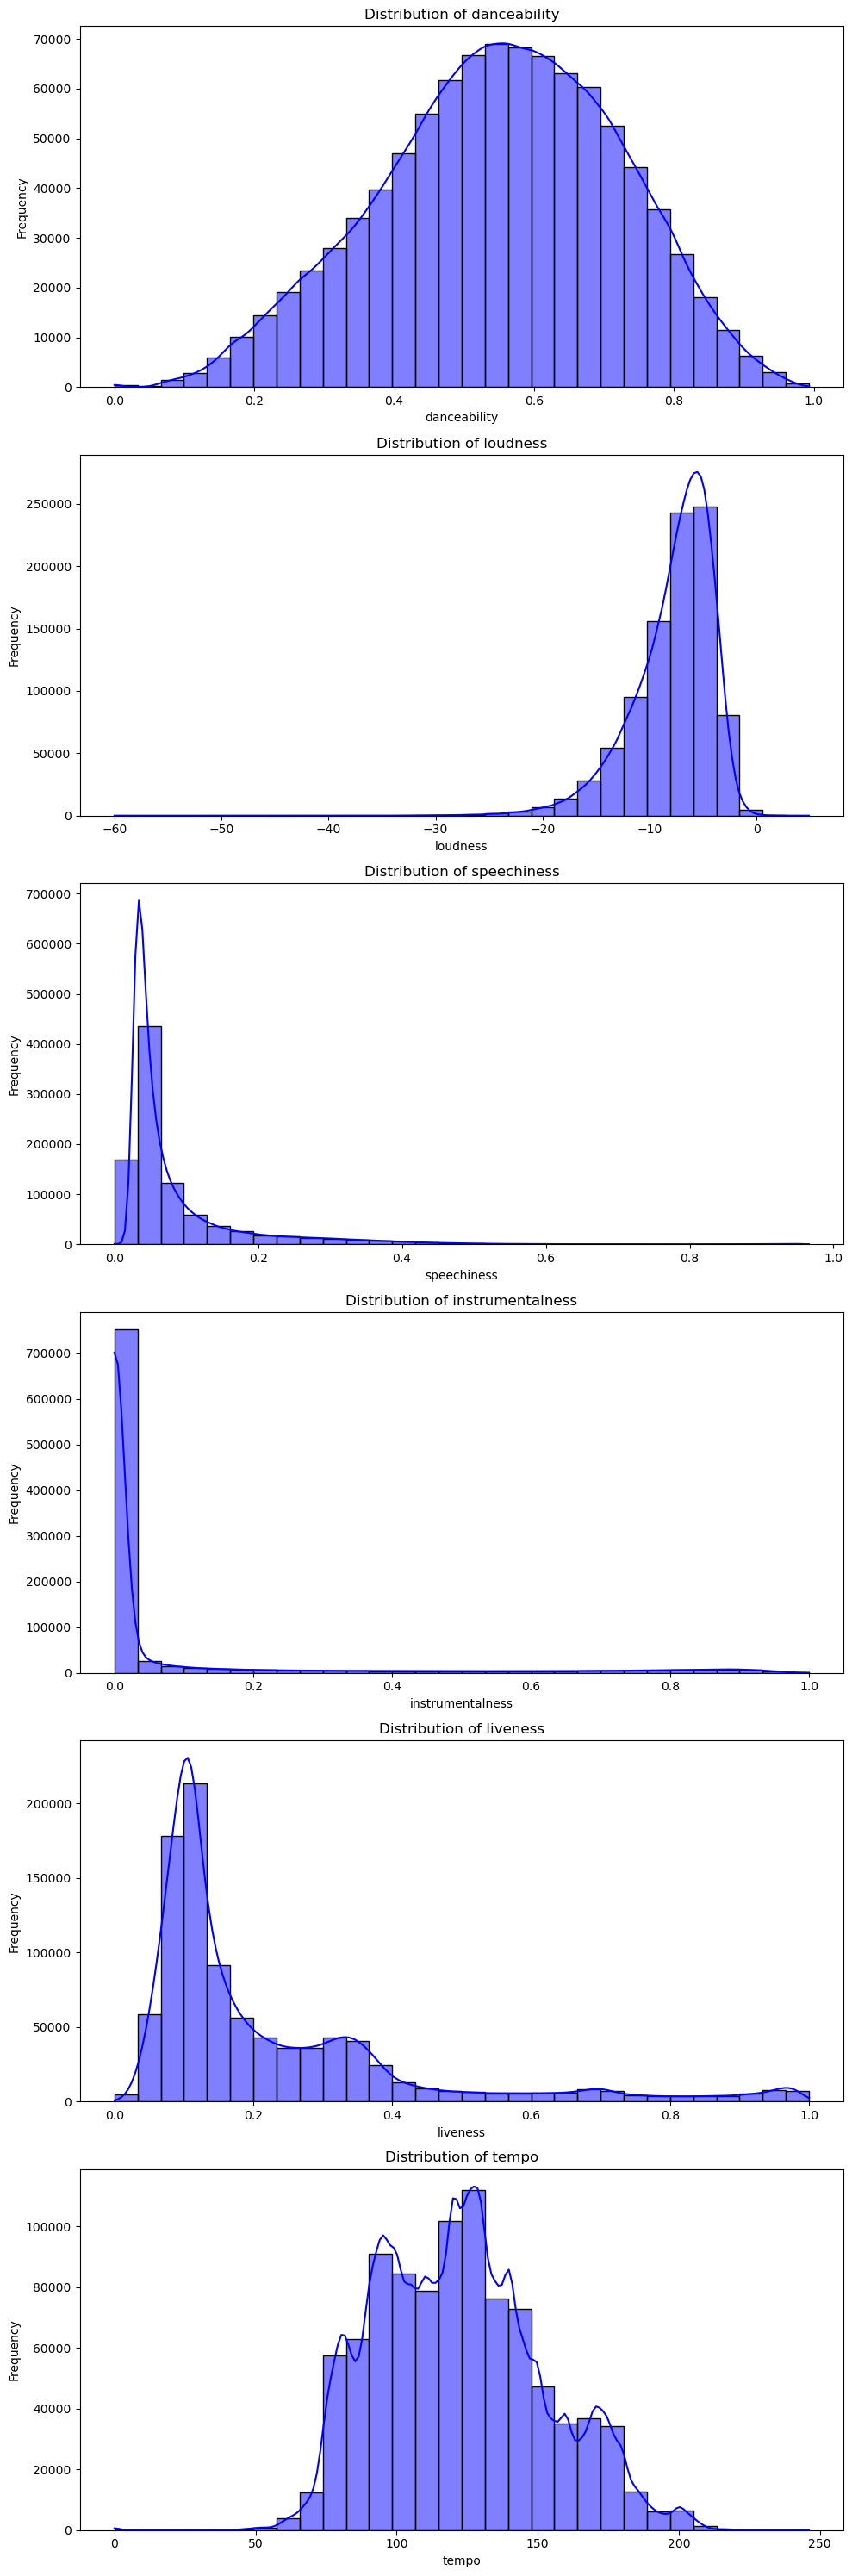

In [23]:
# Ploting histograms to check distributions
fig, axs = plt.subplots(len(numeric_columns), 1, figsize=(10, 30))

for i, col in enumerate(numeric_columns):
    sns.histplot(df_cleaned[col], kde=True, ax=axs[i], bins=30, color='blue')
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

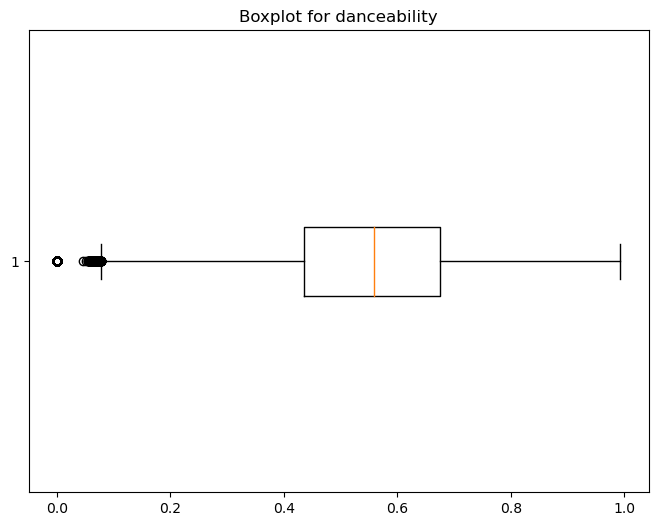

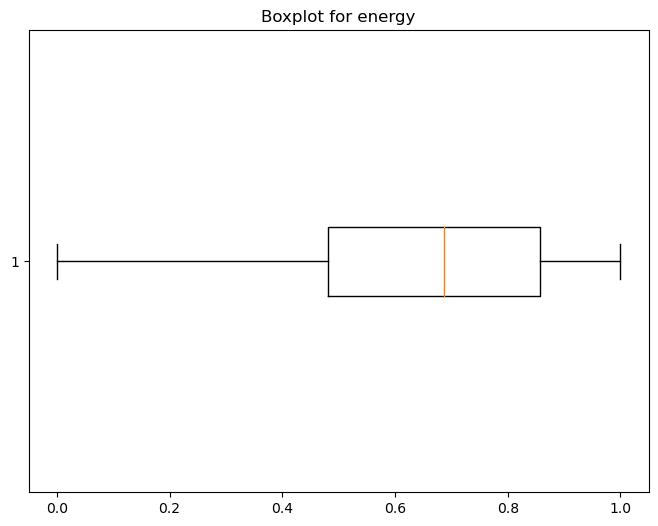

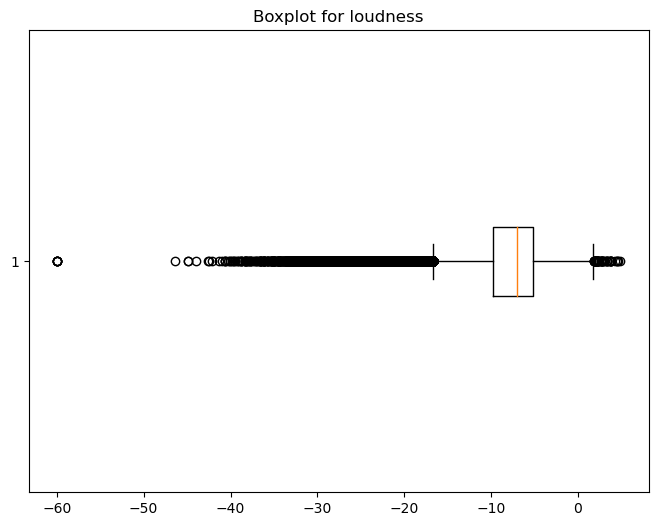

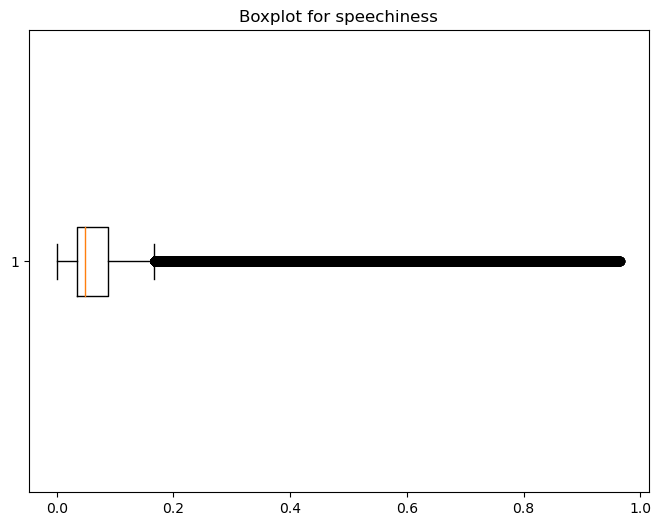

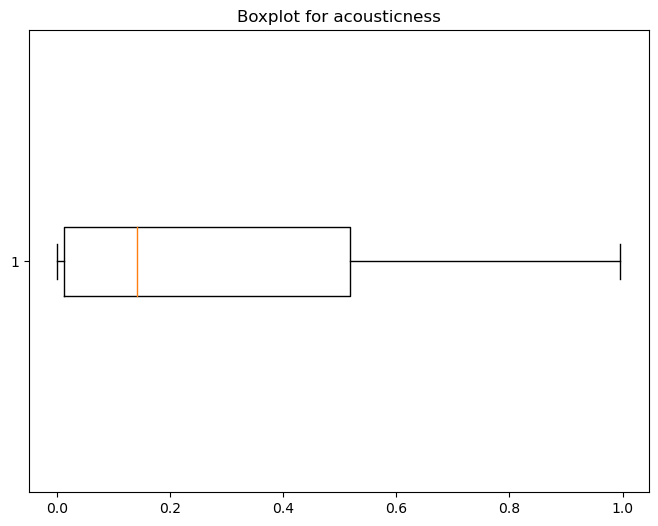

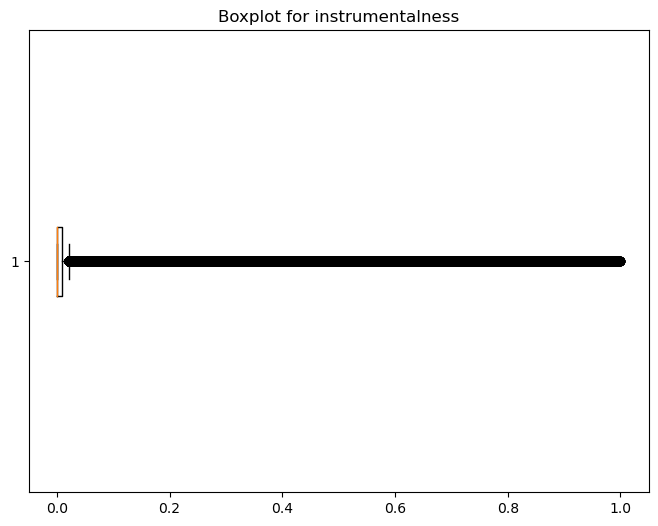

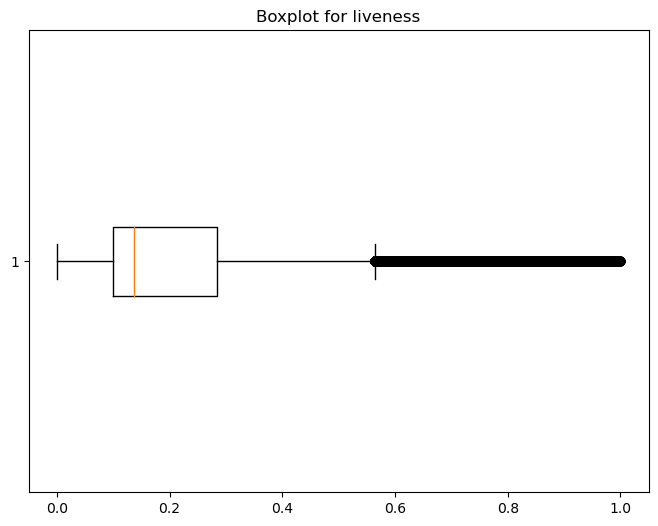

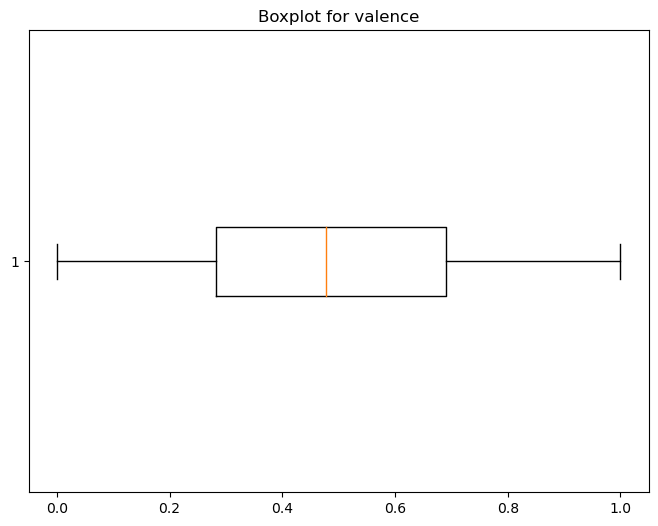

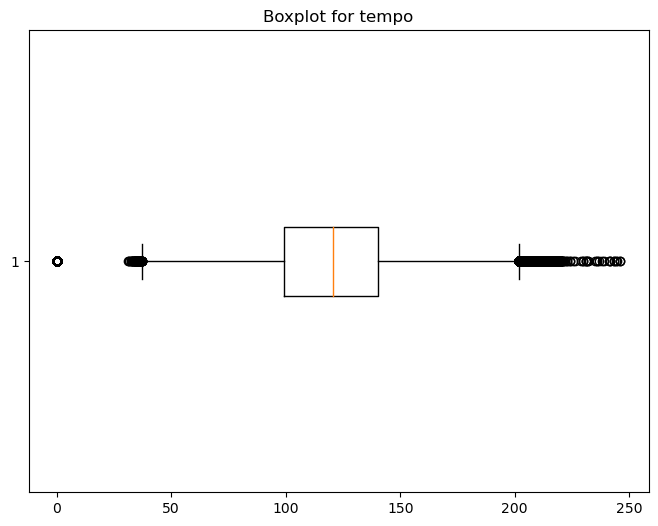

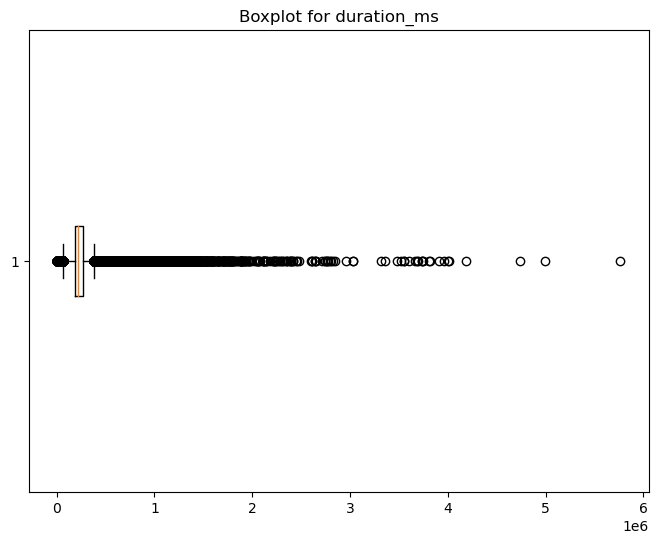

In [24]:
numeric_columns = ['danceability', 'energy', 'loudness', 'speechiness', 
                   'acousticness', 'instrumentalness', 'liveness', 'valence', 
                   'tempo', 'duration_ms']

for col in numeric_columns:
    plt.figure(figsize=(8, 6))
    plt.boxplot(df[col], vert=False)
    plt.title(f'Boxplot for {col}')
    plt.show()

## Explanation of Output:

Danceability: The histogram suggests that most songs have a good level of danceability and show a normal distribution. However, the boxplot reveals some lower outliers

Energy: This feature seems to be quite well distributed across the dataset, with no major outliers visible in either the boxplot or histogram. So there’s no need for transformation here.

Loudness: The boxplot reveals a big number of lower outliers, indicating many very quiet tracks. The histogram also shows a left skewed distribution, with a long left-hand tail.

Speechiness: There are a few upper outliers in the boxplot. The histogram shows the data is skewed to the right, suggesting a log transformation could help bring this distribution closer to normal.

Acousticness, Instrumentalness, and Liveness: These features all show a clear right skewed distribution, with many upper outliers. Since the data is highly skewed, log transformation is needed.

Tempo: Tempo shows a mostly normal distribution with only a few outliers.The overall distribution is fairly stable

Duration (ms): The boxplot reveals several extreme outliers in track length, reflecting particularly long recordings. The histogram shows a right-skewed distribution, but given that longer durations can be valid for live performances or special versions transformation may not be necessary for duration.

# Section 2: Outlier Removal and Data Transformation 

In [25]:
numeric_columns = ['danceability', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'tempo']
outlier_bounds = {}

for col in numeric_columns:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_bounds[col] = (lower_bound, upper_bound)
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

# Final datset after removing the outliers
print(f"Dataset size after outlier removal: {df_cleaned.shape[0]} rows")

Dataset size after outlier removal: 583631 rows


### 3.2 Transforming Skewed Data
we will apply log transformation to columns with highly skewed distributions to bring them closer to a normal distribution.

In [26]:
df_cleaned = df.copy()

df_cleaned['instrumentalness'] = np.log1p(df_cleaned['instrumentalness'])
df_cleaned['speechiness'] = np.log1p(df_cleaned['speechiness'])
df_cleaned['liveness'] = np.log1p(df_cleaned['liveness'])
df_cleaned['acousticness'] = np.log1p(df_cleaned['acousticness'])

### 3.3 Min-Max Scaling for Normalization
we apply Min-Max scaling to normalize the dataset, ensuring all features are on the same scale (between 0 and 1)

In [27]:
scaler = MinMaxScaler()
features_to_normalize = ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'liveness', 'acousticness']
df_cleaned[features_to_normalize] = scaler.fit_transform(df_cleaned[features_to_normalize])

### 3.4 Ploting the histogram
Ploting the histogram again to check the distribution for the transformed columns

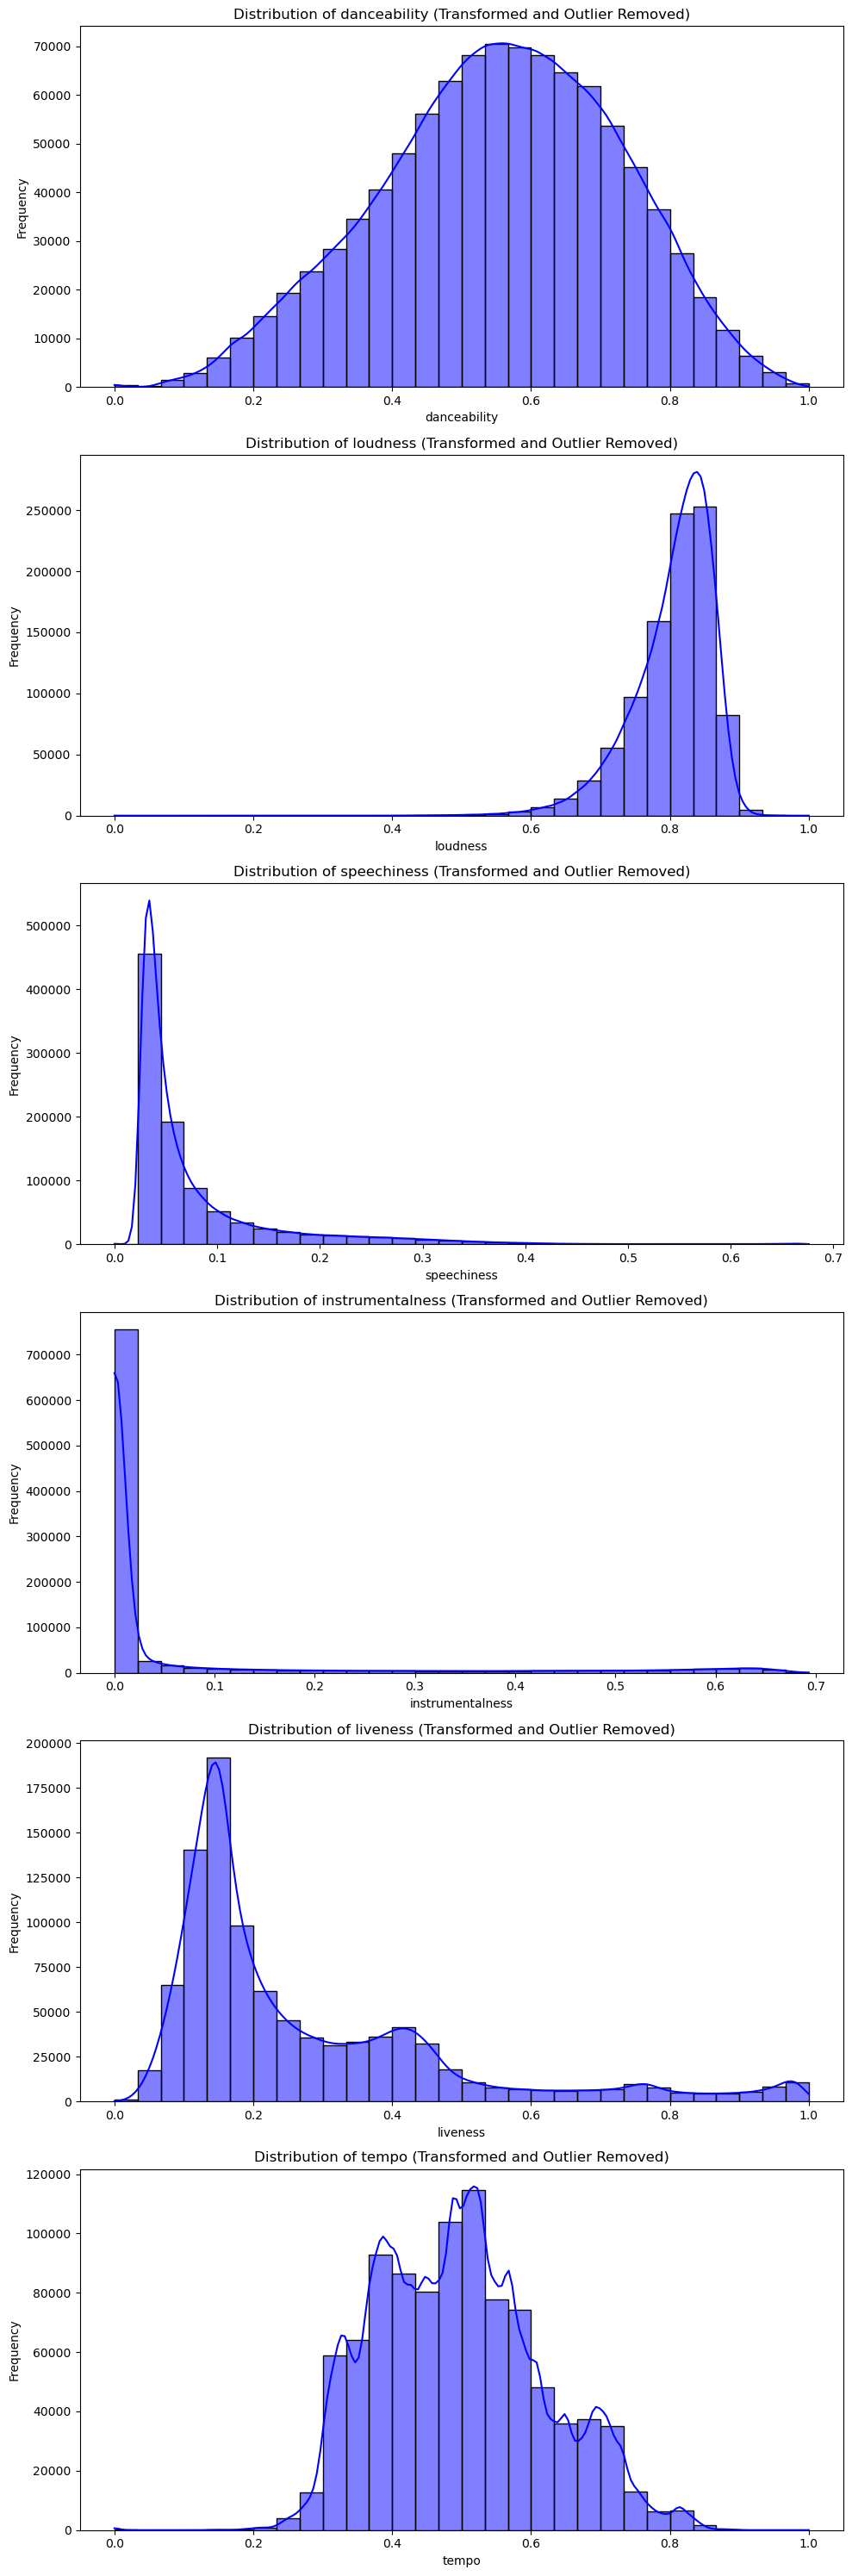

In [28]:
fig, axs = plt.subplots(len(numeric_columns), 1, figsize=(10, 30))

for i, col in enumerate(numeric_columns):
    sns.histplot(df_cleaned[col], kde=True, ax=axs[i], bins=30, color='blue')
    axs[i].set_title(f'Distribution of {col} (Transformed and Outlier Removed)')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [32]:
# Saving to silver folder
df_cleaned.to_csv('silver/music_data_silver_layer.csv', index=False)